In this notebook, I will use PyTorch for the specified cats vs dogs classification task.

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Downloading the dataset

In [3]:
!gsutil -mq cp gs://a/b/c/datasets/cats_vs_dogs_dataset.zip ./  ##use your path

In [ ]:
!unzip cats_vs_dogs_dataset.zip -d /content/drive/MyDrive/Dataset/


In [5]:
import os
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/train/dogs')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/train/cats')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/test/dogs')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/test/cats')))

8995
8995
1227
3505


#### Installing and importing Libraries

In [ ]:
!pip install wandb
!pip install efficientnet_pytorch
!pip install timm

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import os
import wandb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Setting up WANDB
wandb.login(key="Give your key here")
wandb.init(project="CatvsDog_EfficientNetV2B2", name='Run_Without_Pretrained')

### Data Augmentation and Splitting into Train-Validation-Test

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Define paths to your training and test data directories
train_data_dir = '/content/drive/MyDrive/Dataset/dataset/train'
test_data_dir = '/content/drive/MyDrive/Dataset/dataset/test'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train dataset
train_dataset = ImageFolder(root=train_data_dir, transform=transform)

# Calculate the number of samples for validation
validation_size = int(0.15 * len(train_dataset))

# Split the train dataset into train and validation sets using train_test_split
train_indices, validation_indices = train_test_split(
    range(len(train_dataset)),
    test_size=validation_size,
    stratify=train_dataset.targets,  # Making sure the class distribution is preserved
    random_state=42
)

# Create Subset classes for train and validation datasets
train_subset = Subset(train_dataset, train_indices)
validation_subset = Subset(train_dataset, validation_indices)

# Define batch size and create data loaders
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)

# Load test dataset
test_dataset = ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset: {len(train_subset)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Validation dataset: {len(validation_subset)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Test dataset: {len(test_dataset)} images belonging to {len(test_dataset.classes)} classes.")

Train dataset: 15292 images belonging to 2 classes.
Validation dataset: 2698 images belonging to 2 classes.
Test dataset: 4732 images belonging to 2 classes.


### Model Definition

In [ ]:
#to check the list of PyTorch Image Models
timm.list_models()

In [9]:
# Check for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the EfficientNetV2-B2 model
model = timm.create_model('tf_efficientnetv2_b2', pretrained=False, num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Training and validation

In [13]:
# Training loop with model checkpointing and WANDB logging
num_epochs = 15
best_accuracy = 0.0
best_epoch = 0

# Create empty lists to store training and validation loss values (need for plots)
train_losses = []
val_losses = []

# Define the path to the directory where models will be saved
model_save_dir = '/content/drive/MyDrive/Models'

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize variables for tracking training loss and accuracy
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Move inputs and labels to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the training loss
        train_loss += loss.item()

        # Track the accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Print training loss and accuracy for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Train Acc: {train_accuracy:.4f}')

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for tracking validation loss and accuracy
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    for inputs, labels in validation_loader:
        # Move inputs and labels to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Track the validation loss
        val_loss += loss.item()

        # Track the accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(validation_loader)
    val_accuracy = 100 * correct_val / total_val

    # Print validation loss and accuracy for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f} Validation Acc: {val_accuracy:.4f}')

    # Append the losses to the lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


    # Save the model after each epoch to the drive
    checkpoint_filename = os.path.join(model_save_dir, f'PT_EfficientNetV2B2_Not_pretrained_{epoch + 1}.pth')
    torch.save(model.state_dict(), checkpoint_filename)
    # Save the model after each epoch to the bucket
    !gsutil -mq cp {checkpoint_filename} gs://a/b/c/models/cats_vs_dogs_task/rifat/PT_EfficientNetV2B2/model/  #modify cloud path

    # Check if the current model has a better validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch

    # Log metrics to WandB at the end of each epoch
    wandb.log({
        'Train Loss': avg_train_loss,
        'Train Accuracy': train_accuracy,
        'Validation Loss': avg_val_loss,
        'Validation Accuracy': val_accuracy
    })

wandb.finish()

Epoch [1/15] Train Loss: 0.6634 Train Acc: 66.4923
Epoch [1/15] Validation Loss: 3.2839 Validation Acc: 65.2706
Epoch [2/15] Train Loss: 0.6354 Train Acc: 67.8067
Epoch [2/15] Validation Loss: 0.6302 Validation Acc: 66.7161
Epoch [3/15] Train Loss: 0.6173 Train Acc: 68.2056
Epoch [3/15] Validation Loss: 0.6841 Validation Acc: 62.3054
Epoch [4/15] Train Loss: 0.5744 Train Acc: 70.1020
Epoch [4/15] Validation Loss: 0.5497 Validation Acc: 72.1646
Epoch [5/15] Train Loss: 0.5563 Train Acc: 72.4235
Epoch [5/15] Validation Loss: 1.0711 Validation Acc: 72.0534
Epoch [6/15] Train Loss: 0.5638 Train Acc: 72.2992
Epoch [6/15] Validation Loss: 0.6230 Validation Acc: 72.9059
Epoch [7/15] Train Loss: 0.5254 Train Acc: 75.2223
Epoch [7/15] Validation Loss: 0.5540 Validation Acc: 74.8332
Epoch [8/15] Train Loss: 0.5001 Train Acc: 77.3019
Epoch [8/15] Validation Loss: 0.4970 Validation Acc: 78.0578
Epoch [9/15] Train Loss: 0.4519 Train Acc: 79.2964
Epoch [9/15] Validation Loss: 0.4379 Validation Acc: 

Train Accuracy,▁▂▂▂▃▃▅▅▆▆▇▇███
Train Loss,█▇▇▆▅▆▅▄▃▃▂▂▁▁▁
Validation Accuracy,▂▂▁▄▄▄▅▆▇▅▇▇▅█▂
Validation Loss,█▂▂▁▃▂▁▁▁▂▁▁▁▁▂
Train Accuracy,83.71698
Train Loss,0.37631
Validation Accuracy,64.93699
Validation Loss,0.72505


In [14]:
# Load the best model checkpoint based on validation accuracy
best_checkpoint_filename = os.path.join(model_save_dir, f'model_epoch_{best_epoch + 1}.pth')
print(best_checkpoint_filename)

/content/drive/MyDrive/Models/model_epoch_14.pth


### Testing the model on test set

In [10]:
# reduce batch size if CUDA ran out of memory. (after restarting runtime)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#loading model
model.load_state_dict(torch.load('/content/drive/MyDrive/Models/PT_EfficientNetV2B2_Not_pretrained_14.pth'))

# Calculate test accuracy using the best model
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

for inputs, labels in test_loader:
    # Move inputs and labels to the GPU if available
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Track the test loss
    test_loss += loss.item()

    # Track the accuracy
    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

# Print test loss and accuracy using the best model
print(f'Best Model Test Loss: {avg_test_loss:.4f} Test Acc: {test_accuracy:.4f}')

# Gather true and predicted labels for classification report and confusion matrix
true_labels = []
predicted_labels = []

for inputs, labels in test_loader:
    # Move inputs to the GPU if available
    inputs = inputs.to(device)

    # Forward pass
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)



Best Model Test Loss: 0.3447 Test Acc: 85.1860


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3505
           1       0.69      0.76      0.72      1227

    accuracy                           0.85      4732
   macro avg       0.80      0.82      0.81      4732
weighted avg       0.86      0.85      0.85      4732



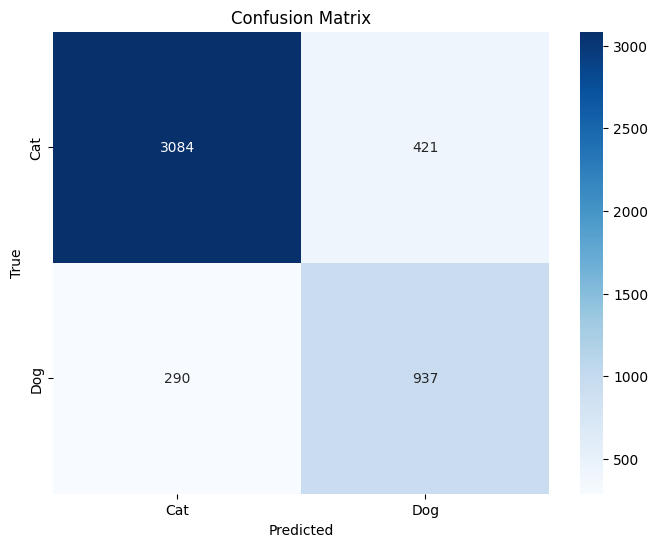

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()